In [242]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk.classify import SklearnClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import sys
import string
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [244]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    
    
    with open("fake_news.tsv") as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue   
            d.append(line)
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))       

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text,"False")),label)) # pre_process now takes 2 arguments, set true when want to do stop word removal 
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text,"False")),label))
        

In [245]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    
    label=convert_label(data_line[1]) #label element: data_line[1] read from file
    text=data_line[2] #statement element: data_line[2] read from file
    return (label, text)

In [246]:
def pre_process(text,stopword="False"):
    # Sentence segmentation is already done as the sentences are provided as different rows
    # word tokenisation
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings by replacing the punctations by the string
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings by replacing the punctations by the string
    tokens = re.split(r"\s+",text) # with space as delimeter it split the spaced text
    tokens = [t.lower() for t in tokens]
    wnl = WordNetLemmatizer() 
    for i in range(0,len(tokens)):
      tokens[i]=wnl.lemmatize(tokens[i]) # Lemmatizing strings to thier dictionry forms
    if stopword=="True": # Use only to check that the accuracy drops by removing stop words
      N = stopwords.words('english')
      word_stop=[]
      for i in tokens:
        if i not in N:
          word_stop.append(i)
      x1=[]
      for i in range(2,len(word_stop)):
        x1.append(('{0}*{1}'.format(word_stop[i-2],''.join(word_stop[i-1])))) #Creating Bigram
    
      return x1
    else:
      x=[]
      for i in range(2,len(tokens)):
        x.append(('{0}*{1}'.format(tokens[i-2],''.join(tokens[i-1])))) #Creating Bigram
    
    return x


In [247]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    
    local_dict={}
    x1=[]
    st=["percent","state","years","states","year","people","million","would","jobs","one","us","new","since","texas","every"]
    for i in range(2,len(st)):
      x1.append(('{0}*{1}'.format(st[i-2],''.join(st[i-1])))) #gluing the frequent Real words in the same format as Bigram of tokens for comaprison
    

    unglue="False"

    if unglue=="False": # Accuracy reduces if we unglue the tokens and then check, hence seeting to false
      for i in tokens:
        if i in local_dict:
            if i in x1:
              local_dict[i]+=5 # Adding 5 to the value of key if key already present in dictionary and also present in frequent words
            else:
              local_dict[i]+=1 # Adding 1 to the value of key if key already present in dictionary and not present in frequent words
        else:
          
            local_dict[i]=1 # Adding key-value(value as 1) pair to the dictionary
    if unglue=="True":  # Set to true only if you wish to verify that accuracy reduces from 60.2% to 59.1%
      st=["percent","state","years","states","year","people","million","would","jobs","one","us","new","since","texas","every"]
      local_dict={}
      for i in tokens:
        if i in local_dict:
            z=i
            x=z.split("*")
            if x[0] in st or x[1] in st:
              local_dict[i]+=5  #Adding 5 to the value of key if key already present in dictionary and not present in frequent words
            else:
              local_dict[i]+=1  #Adding 1 to the value of key if key already present in dictionary and not present in frequent words
        else:
            z=i
            x=z.split("*")
            if x[0] in st or x[1] in st:
              local_dict[i]=5 #Adding key-value(value as 5) pair to the dictionary if present in frequent word
            else:
              local_dict[i]=1   # Adding key-value(value as 1) pair to the dictionary if not preset in frequent word
            
    for w in tokens:
          try:
            i = global_feature_dict[w] # Checks if the key is already present in the dictionary, do nothing
          
          except KeyError:
            i = len(global_feature_dict) + 1 # If it is not present then we add 1 to the length of the dictioanry
                
            global_feature_dict[w] = i # Then assign the new length as the value to the new key
            
    return local_dict       

In [2]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data,lin,mul,log,ran): # using boolean values to select differet models just to check accuracy for reference.
    print("Training Classifier...")
    
    if lin=="True":
      pipeline = Pipeline([('model', LinearSVC(class_weight={0:1.1,1:1},C=0.006))]) #Decreasing cost parameter to penalizing samples inside the marging less
                                                                                    #And giving more weight to Real
    elif mul=="True":
      pipeline = Pipeline([('model', MultinomialNB())])
    elif log=="True":
      pipeline = Pipeline([('model', LogisticRegression())])
    elif ran=="True":
      pipeline = Pipeline([('model', RandomForestClassifier())])
    
    
    return SklearnClassifier(pipeline).train(data)

In [249]:
def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    cv=np.array([])
    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    j=0

    for i in range(0,len(dataset),int(fold_size)):
        data_fold=dataset[0:i]+dataset[i+fold_size:]
        test_fold=dataset[i:i+fold_size]
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        classifier=train_classifier(data_fold,"True","False","Flase","False")
        predict=predict_labels([x[0] for x in test_fold],classifier)
        if i ==7380:
          global_test.append([x[1] for x in test_fold])
          global_predict.append(predict)
          global_test_text.append([x[0] for x in test_fold])
        accuracy.append(accuracy_score([x[1] for x in test_fold],predict))
        precision.append(precision_score([x[1] for x in test_fold], predict, average='weighted'))
        recall.append(recall_score([x[1] for x in test_fold], predict, average='weighted'))
        f1.append(f1_score([x[1] for x in test_fold], predict, average='weighted'))

        
    cv=[100*np.mean(accuracy),100*np.mean(precision),100*np.mean(recall),100*np.mean(f1)]
           
    return cv

In [250]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [4]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset
global_test=[]
global_predict=[]
global_test_text=[]
global_text=[]
d=[]


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)


# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')




Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...


NameError: ignored

In [252]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


[60.2799471344467, 59.65151068538373, 60.2799471344467, 58.95256220964574]

In [253]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds,labels=labels)
    print(cm)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

[[362 117]
 [192 141]]


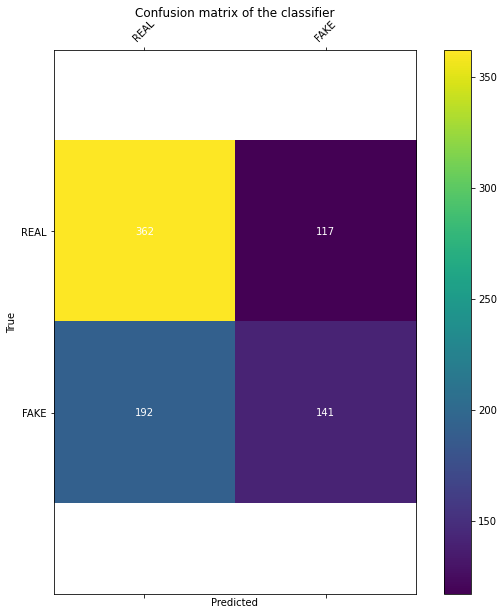

In [254]:
confusion_matrix_heatmap(global_test[0],global_predict[0],["REAL","FAKE"]) #Plotting confusion matrix on the last fold of data